# FindOpenSimulationModels

An experiment to find simulation models such as FMU and Modelica files on the open internet. I am curious how prevalent they are and whether they have inputs and outputs that would be suitable for reinforcement learning environments.

In [1]:
# While developing, limit the amount of data that is downloaded.
# Set to False when ready to download all the data.
is_testing = False

fmu_list_filename = 'results/github-fmu-search.txt'
fmu_analysis_filename = 'results/github-fmu-analysis.csv'
import importlib

## FMUs on GitHub

Let's start by looking at FMU files that exist in GitHub repositories.

### Manual search

We can enter `extension:fmu` in the GitHub search box and choose `All GitHub', resulting in the query https://github.com/search?q=extension%3Afmu&type=code. This resulted in 10,841 code results. That's good that there are thousands of FMU files out there! However, we would need to hit the *Next* button to page through a few files at a time and manually copy their URLs from the web page.

### GitHub API search

Next, let's try doing this programmatically with the [GitHub search API](https://docs.github.com/en/rest/search). Unfortunately, this doesn't seem to be possible based on this [Reddit](https://www.reddit.com/r/github/comments/dr19uu/finding_all_files_with_a_certain_extension/) and [Stack Overflow](https://stackoverflow.com/questions/58673751/find-all-files-with-certain-filetype-on-github) discussion from three years ago. My results were the same.

Here's what I tried (TLDR it didn't work):

A **repository** search of `https://api.github.com/search/repositories?q=extension:fmu` only returns one result. It did indeed find a [repository](https://github.com/INTO-CPS-Association/distributed-maestro-fmu) that contains a [singlewatertank-20sim.fmu](https://github.com/INTO-CPS-Association/distributed-maestro-fmu/blob/95922d63eb50c17609320c180319f23d17173c7f/bundle/src/test/resources/singlewatertank-20sim.fmu) file. But there should be many more repositories. It seems that the extensions qualifier is doing something but--if it works--it is only scanning a small subset of GitHub.

The [repository API doc](https://docs.github.com/en/rest/search?apiVersion=2022-11-28#search-repositories) says to see [Searching for repositories](https://docs.github.com/en/search-github/searching-on-github/searching-for-repositories) for a detailed list of qualifiers. In that documentation, [Search based on the contents of a repository](https://docs.github.com/en/search-github/searching-on-github/searching-for-repositories#search-based-on-the-contents-of-a-repository) states:

> Besides using in:readme, it's not possible to find repositories by searching for specific content within the repository. To search for a specific file or content within a repository, you can use the file finder or code-specific search qualifiers.

A **code** search of `https://api.github.com/search/code?q=extension:fmu` returns a `Validation Failed` error with `Must include at least one user, organization, or repository`. So it seems it is not possible to search all of GitHub in this way. In the documentation, [Considerations for code search](https://docs.github.com/en/rest/search?apiVersion=2022-11-28#considerations-for-code-search) states:

> * Only files smaller than 384 KB are searchable.
> * ...
> * You must always include at least one search term when searching source code. For example, searching for language:go is not valid, while amazing language:go is.

This will not work for FMU files because we want all of them (not just FMUs containing some particular search term), they are larger than 384 KB, and they are in a binary (zip) format that wouldn't work with a text search.

In the [Reddit thread](https://www.reddit.com/r/github/comments/dr19uu/comment/f6ezx4e/?utm_source=share&utm_medium=web2x&context=3) OP Gasp0de also looked into using [GH Archive](https://www.gharchive.org/), but it it doesn't look like GH Archive includes an event type with file information about the contents of repositories/commits.

### Scraping

Based on the [Information Usage Restrictions](https://docs.github.com/en/site-policy/acceptable-use-policies/github-acceptable-use-policies#7-information-usage-restrictions), it appears that web scraping of GitHub is permitted:

> You may use information from our Service for the following reasons, regardless of whether the information was scraped, collected through our API, or obtained otherwise:
> 
> Researchers may use public, non-personal information from the Service for research purposes, only if any publications resulting from that research are open access.
Archivists may use public information from the Service for archival purposes.

We are researching the nature of FMU files that are present on GitHub with the intent to crate an archive or index of them, so that seems to fit. We don't expect it will be a tremendous amount of data and we won't be spamming anyone. Let's give it a try.

In [3]:
import requests
search_url = 'https://github.com/search?q=extension%3Afmu&type=code'
print(f'Getting: {search_url}')
search = requests.get(search_url)
print(f'Result: status code = {search.status_code}, url = {search.url}')
# print response lines containing the string <title>
for line in search.text.splitlines():
    if '<title>' in line:
        print(line)

Getting: https://github.com/search?q=extension%3Afmu&type=code
Result: status code = 200, url = https://github.com/login?return_to=https%3A%2F%2Fgithub.com%2Fsearch%3Fq%3Dextension%253Afmu%26type%3Dcode
  <title>Sign in to GitHub · GitHub</title>


It is requiring us to log in, so we won't just be able to get the results by fetching URLs. Let's try scraping the search results using browser automation.

In [2]:
# It is requiring us to log in, so we won't just be able to get the results by fetching URLs. Let's try scraping the search results using browser automation.
import ScrapeGitHubFilesByExtension
importlib.reload(ScrapeGitHubFilesByExtension) # reload changes to ScrapeGitHubFilesByExtension.py every run
# Open browser and get ready to scrape search results
scrape = ScrapeGitHubFilesByExtension.ScrapeGitHubFilesByExtension('fmu', fmu_list_filename, filter_out_private_repositories=True, is_testing=is_testing)

Opening: https://github.com/search?q=extension:fmu&type=code
Use the web browser window to log in to GitHub...
First page of search results loaded
10,845 code results
Found 100 pages of results
Limiting to 3 pages in testing mode


In [4]:
# Page through the search results to scrape a list of FMU URLs
# Note that, during development, this cell can be run multiple times while the logged-in browser is still open.
scrape.scrape()

Done scraping 3 pages * 4 orders
This scan has found 0 new FMUs, 109 already known FMUs, 1 FMUs from private repos (filtered out)
The entire collection now has 3879 FMUs

Retries:
  succeeded after 0 retries: 9 pages
  succeeded after 1 retries: 1 pages
  failed: 0 pages


In [5]:
# Close the browser
del scrape

We weren't able to identify all of the 10,841 FMUs reported by GitHub search, but we do have several thousand. This is a good enough sampling that we will move on to take a look at these files to see if they would be suitable as reinforcement learning environments.

### Downloading

Next, let's download FMU files from the GitHub URLs we collected.

In [5]:
import DownloadGitHubFiles
importlib.reload(DownloadGitHubFiles) # reload changes to DownloadGitHubFiles.py every run
download = DownloadGitHubFiles.DownloadGitHubFiles(fmu_list_filename, is_testing)
download.download()
del download

Done
600 files downloaded, 2 failed, 3277 skipped (already cached)

Errors:
https://raw.githubusercontent.com/microsoft/FMU-bonsai-connector/937ce984d0896681132fde209ef06048f14a5850/samples/Integrator.fmu: 404 - 404: Not Found
https://raw.githubusercontent.com/microsoft/FMU-bonsai-connector/937ce984d0896681132fde209ef06048f14a5850/samples/vanDerPol.fmu: 404 - 404: Not Found


### Analysis

Now we can analyze our collection of FMU files.

In [7]:
import AnalyzeFmuFiles
importlib.reload(AnalyzeFmuFiles) # reload changes to AnalyzeFmuFiles.py every run
import pandas
analyze = AnalyzeFmuFiles.AnalyzeFmuFiles('results/downloads', fmu_analysis_filename, is_testing)
df = analyze.analyze()
display(df)

Done
Analyzed 229 analyzed files, 151 exceptions, 3491 skipped (already cached)
The entire collection now has 3714 files that were analyzed successfully

Exceptions:
results/downloads\Andy53\ERC.net\ERC_obj_.cache_build_o31wtgeg.yb2_xchmudqf.fmu: Exception: File is not a zip file
results/downloads\DLR-VSDC\IEEE-MVC-2023\MVCExportedFMUs_MVC2023_Hash_11426c46.fmu: Exception: File is not a zip file
results/downloads\DLR-VSDC\IEEE-MVC-2023\MVCExportedFMUs_MVC2023_Hash_3eb78153.fmu: Exception: File is not a zip file
results/downloads\DLR-VSDC\IEEE-MVC-2023\MVCExportedFMUs_MVC2023_Hash_45a0ea85.fmu: Exception: File is not a zip file
results/downloads\DLR-VSDC\IEEE-MVC-2023\MVCExportedFMUs_MVC2023_Hash_47c69bf5.fmu: Exception: File is not a zip file
results/downloads\DLR-VSDC\IEEE-MVC-2023\MVCExportedFMUs_MVC2023_Hash_9bf0e383.fmu: Exception: File is not a zip file
results/downloads\DLR-VSDC\IEEE-MVC-2023\MVCExportedFMUs_MVC2023_Hash_ddadadfe.fmu: Exception: File is not a zip file
results/dow

,Validity Has Exception,Validity Problem Count,Validity Message,FMI Version,Co-Simulation,Model Exchange,Param Count,Input Count,Output Count,Generation Tool
Filename,,,,,,,,,,
results/downloads\AIT-IES\FMITerminalBlock\doc...,False,0,<NA>,1.0,False,True,6,1,3,OpenModelica Compiler OpenModelica v1.11.0 (32...
results/downloads\AIT-IES\detb-lablink-example...,False,0,<NA>,2.0,True,True,0,2,3,"Dymola Version 2020x (64-bit), 2019-10-10"
results/downloads\AIT-IES\detb-lablink-example...,False,1,ModelStructure/InitialUnknowns does not contai...,2.0,True,True,3,1,3,"Dymola Version 2020x (64-bit), 2019-10-10"
results/downloads\AIT-IES\detb-lablink-example...,False,0,<NA>,2.0,True,True,3,6,3,"Dymola Version 2020x (64-bit), 2019-10-10"
results/downloads\AIT-Lablink\lablink-fmusim\s...,False,0,<NA>,2.0,False,True,7,1,2,"Dymola Version 2019 FD01 (64-bit), 2018-10-10"
...,...,...,...,...,...,...,...,...,...,...
results/downloads\zhangjinyiyi\SmallTest\fmi_P...,False,1,ModelStructure/InitialUnknowns does not contai...,2.0,True,False,0,0,2,PythonFMU 0.6.2
results/downloads\zhangjinyiyi\SmallTest\fmi_R...,False,1,ModelStructure/InitialUnknowns does not contai...,2.0,True,False,1,2,2,PythonFMU 0.6.2
results/downloads\zhangzhizza\unnc_abee1025_re...,False,0,<NA>,1.0,True,False,0,4,2,<NA>


### Results

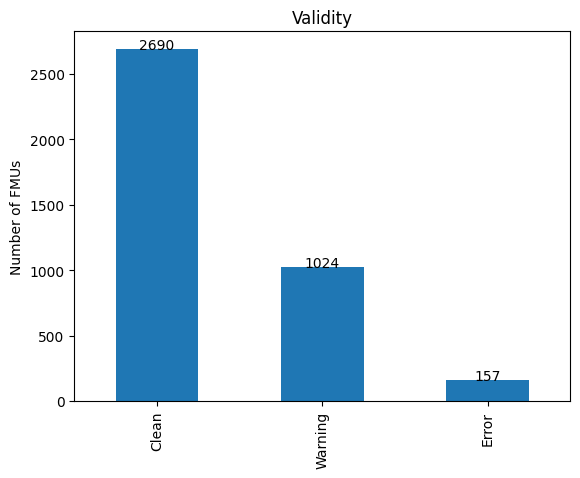

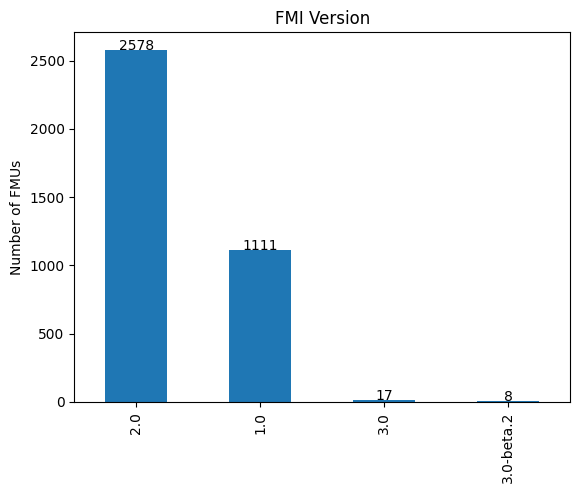

C:\Users\forre\AppData\Local\Temp\ipykernel_30176\535307310.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Interface Type'] = 'Neither'


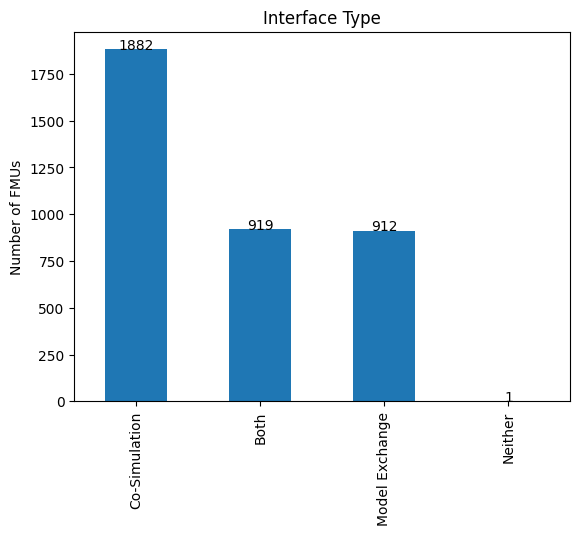

In [2]:
# TODO How to fix SettingWithCopyWarning in these results?

import matplotlib.pyplot as plt
import pandas
import numpy as np
import AnalyzeFmuFiles
importlib.reload(AnalyzeFmuFiles) # reload changes to AnalyzeFmuFiles.py every run

analyze_results = AnalyzeFmuFiles.ResultStore(fmu_analysis_filename)
df = analyze_results.df

def plot_categorical_count_bar_chart(column_name, wide=False, title=None):
    if wide:
        plt.figure(figsize=(12, 5))
    df_counts = df[column_name].value_counts()
    df_counts.plot.bar()
    # Show numbers on the bars
    for index, value in enumerate(df_counts):
        plt.text(index, value, str(value), horizontalalignment='center')
    plt.ylabel('Number of FMUs')
    if title is None:
        title = column_name
    plt.title(title)
    plt.show()

# Plot validity
df['Validity'] = 'Clean'
df.loc[df['Validity Has Exception'] == True, 'Validity'] = 'Error'
df.loc[df['Validity Problem Count'] > 0, 'Validity'] = 'Warning'
df_validity = df['Validity'].value_counts()
plot_categorical_count_bar_chart('Validity')

# Remove the FMUs with errors from further results
df = df.loc[df['Validity Has Exception'] == False]

# Plot FMI version
plot_categorical_count_bar_chart('FMI Version')

# Plot interface type
# TODO: Add scheduled execution to analysis
df['Interface Type'] = 'Neither'
df.loc[df['Model Exchange'] == True, 'Interface Type'] = 'Model Exchange'
df.loc[df['Co-Simulation'] == True, 'Interface Type'] = 'Co-Simulation'
df.loc[(df['Model Exchange'] == True) & (df['Co-Simulation'] == True), 'Interface Type'] = 'Both'
plot_categorical_count_bar_chart('Interface Type')

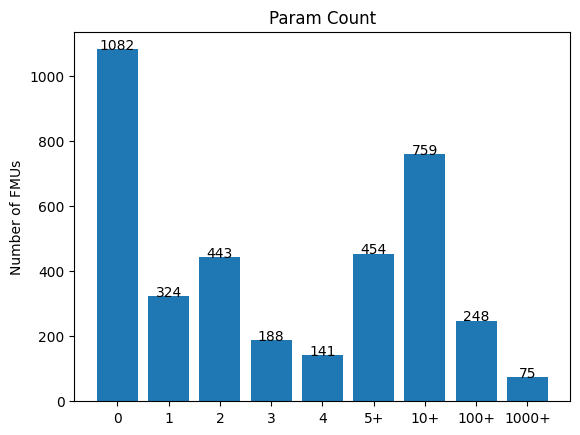

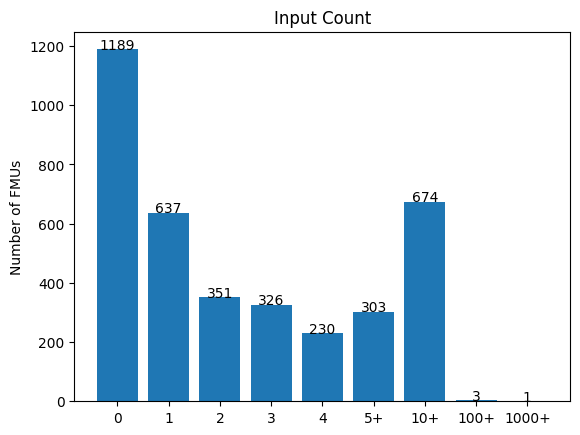

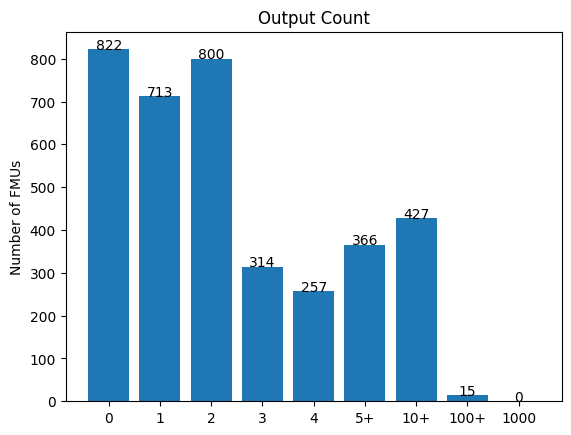

In [4]:
def plot_numerical_count_bar_chart(column_name, title=None):
    # Get max count rounded up to next power of 10
    max_count = df[column_name].max()
    max_count = 10 ** np.ceil(np.log10(max_count))
    bin_edges = [0, 1, 2, 3, 4, 5, 10, 100, 1000, max_count + 1]
    hist, bins = np.histogram(df[column_name], bins=bin_edges)
    plt.bar(range(len(hist)), hist)
    xticks = [0] * len(hist)
    for bin in range(len(hist)):
        # Show each bin as a range (if it is more than one number)
        bin_start = bin_edges[bin]
        bin_end = bin_edges[bin + 1] - 1
        xticks[bin] = f'{bin_start}' if bin_start == bin_end else f'{bin_start}+'
        # Show numbers on the bars
        plt.text(bin, hist[bin], str(hist[bin]), horizontalalignment='center')
    plt.xticks(range(len(hist)), xticks)
    plt.ylabel('Number of FMUs')
    if title is None:
        title = column_name
    plt.title(title)
    plt.show()

plot_numerical_count_bar_chart('Param Count')
plot_numerical_count_bar_chart('Input Count')
plot_numerical_count_bar_chart('Output Count')

C:\Users\forre\AppData\Local\Temp\ipykernel_30176\1991193975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Generation Tool Group'] = df['Generation Tool'].str.split(' ').str[0]


OpenModelica 874: OpenModelica Compiler OpenModelica v1.16.0-dev.03 (64-bit), OpenModelica Compiler OpenModelica v1.15.0-dev-22-g5aea5c3aa6 (64-bit), OpenModelica Compiler OpenModelica v1.14.1 (64-bit), OpenModelica Compiler v1.9.4-dev.719+ga6c7cb2, OpenModelica Compiler OpenModelica 1.18.1
Dymola 568: Dymola Version 2021 (64-bit), 2020-05-13, Dymola Version 2019 FD01 (64-bit), 2018-10-10 (requires license to execute), Dymola Version 2019 (64-bit), 2018-04-11, Dymola Version 2012 FD01 (32-bit), 2011-11-22, Dymola Version 2021 (64-bit), 2020-04-17 (requires license to execute)
JModelica.org 357: JModelica.org
20-sim 151: 20-sim, 20-sim 4.7.1, 20-sim 4.7.0, 20-sim 4.8.2, 20-sim 4.8.0
idf-to-fmu-export-prep-win.exe 101: idf-to-fmu-export-prep-win.exe
Simulink 87: Simulink (R2020b), Simulink (R2020a), Simulink (R2021a), Simulink (R2022a), Simulink (R2022b)
FMI 83: FMI Toolbox 2.6.4 from Modelon run at MATLAB (R2019a) win64, FMI Toolbox 2.6.1b1 from Modelon run at MATLAB (R2017a) win64, FMI

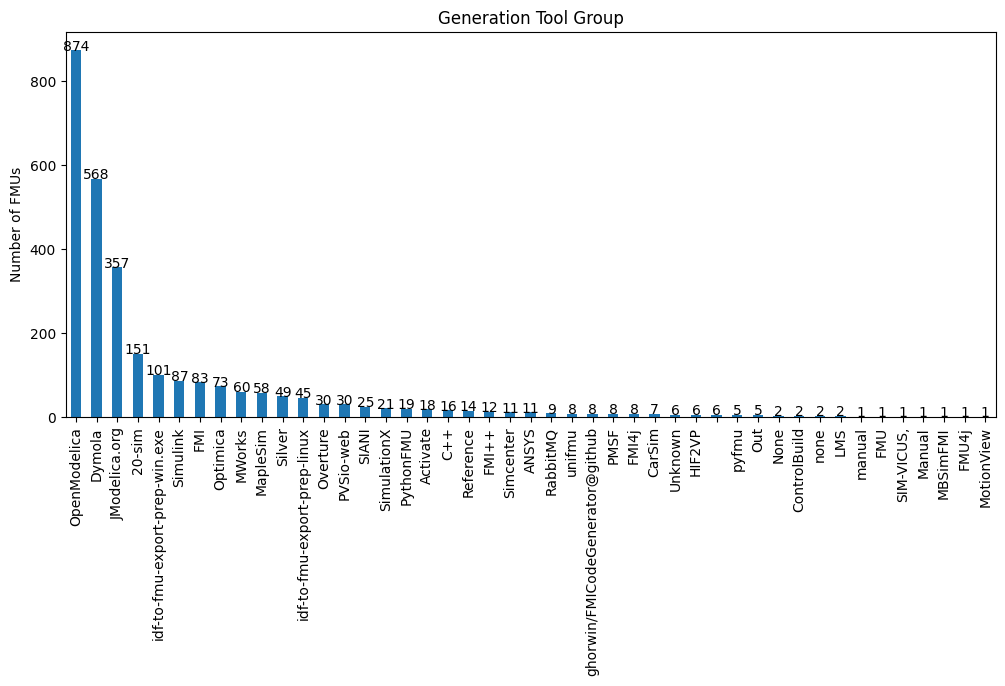

In [6]:
# Let's see if we can break generation tool strings into usable sets
generation_counts = df['Generation Tool'].value_counts()
# Lots of these are just different versions of the same tool.

# Let's try grouping by the first word in the tool name.
df['Generation Tool Group'] = df['Generation Tool'].str.split(' ').str[0]
generation_group_counts = df['Generation Tool Group'].value_counts()

# print each element of generation_group_counts, in order of decreasing count
for group in generation_group_counts.index:
    # build a string of the first few examples of the full tool names from generation_counts
    max_examples = 5
    generation_counts_matching_group = generation_counts[generation_counts.index.str.startswith(group + ' ')]
    examples = [generation_counts_matching_group.index[i] for i in range(min(max_examples, len(generation_counts_matching_group.index)))]
    print(f'{group} {generation_group_counts[group]}: {", ".join(examples)}')

# Skip groups with fewer than 5 FMUs
generation_group_counts_min_5 = generation_group_counts[generation_group_counts > 5]

print(f'Unique of tool strings {len(generation_counts)}, grouped by first word {len(generation_group_counts)}, with at least 5 FMUs {len(generation_group_counts_min_5)}')
plot_categorical_count_bar_chart('Generation Tool Group', wide=True)


## Future Work

- Security note: Executable code in FMU files should be treated as untrusted!
- Statistics about FMUs (# params/inputs/outputs, OS platforms)
- Take a closer looks at a sampling of FMUs to see if they can be understood and controlled to achieve some sort of objective
- How to handle versioning of FMU files? The URLs are https://github.com/{username}/{repository}/blob/{commit_hash}/{file_path}. We could eventually have multiple commit hashes for different versions of the same file. Should we keep them all? Or just the latest? Also note that branch name could be used instead of commit_hash to reference the latest version in a branch. Perhaps we should convert the commit hashes to reference the latest version in the default branch?
- There are many [limitations on GitHub code search](https://docs.github.com/en/search-github/searching-on-github/searching-code#considerations-for-code-search). What would be a better way to find files on GitHub. An archive or crawler?
- Other file types (Modelica, MATLAB, ...?)
- Internet search (files outside GitHub)